In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import mne_bids 
import mne_bids.utils 
import pandas as pd
from fooof import FOOOF,FOOOFGroup

In [2]:
def compute_tfr_epochs(epochs, freq_range_val, method='multitaper', average_trials=False):
    '''
    This function takes an MNE epochsArray and computes the time-frequency
    representatoin of power using either multitapers or wavelets. 
    Time-frequnecy parameters are set to replicate Fellner et al.
    Due to memory demands, this function should be run on single-channel data, 
    or results can be averaged across trials.
    '''
    
    if method == 'multitaper':
        # set paramters for TF decomposition
        #freq = np.logspace(*np.log10([freq_range_val[0],freq_range_val[1]]),256)
        freq = np.arange(freq_range_val[0], freq_range_val[1], 1)
        time_window = 0.5
        n_cycles = freq / (1/time_window) 
        freq_bandwidth = 10 # Hz
        time_bandwidth = freq_bandwidth * time_window 
        
        # TF decomposition using multitapers
        tfr = mne.time_frequency.tfr_multitaper(epochs, freqs=freq, n_cycles=n_cycles, 
                             time_bandwidth=time_bandwidth,
                             use_fft=True, return_itc=False, 
                             average=average_trials, verbose=False)
    
        return tfr

In [3]:
deriv_bids_root = '/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS'
mne_bids.print_dir_tree(deriv_bids_root, max_depth=4)

|Derivatives_Proyecto_LFA-ENYS_BIDS/
|--- README
|--- Referencias_guia_tener_en_cuenta.odt
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-06/
|------ ses-day1/
|--------- sub-06_ses-day1_scans.tsv
|--------- PSD_epochs/
|------------ sub-06_ses-day1_desc-ctrTask_spectrumPSD_epo-epoch.npz
|------------ sub-06_ses-day1_desc-ctrTask_spectrumPSD_epo-rest.npz
|------------ sub-06_ses-day1_desc-ctrTask_spectrumPSD_epo-task.npz
|--------- ieeg/
|------------ sub-06_ses-day1_selectedChannels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_channels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_events.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_ieeg.edf
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_ieeg.json
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm2_channels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm2_events.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSeg

In [4]:
session = 'day1'
datatype = 'ieeg'
subjects = mne_bids.get_entity_vals(deriv_bids_root, 'subject')
tasks = mne_bids.get_entity_vals(deriv_bids_root, 'task')
suffix = 'ieeg'

# Indicar el codigo de descripcion del archivo 'desc'
desc_posible = ['ctrTask','secTask']

print(mne_bids.get_entity_vals(deriv_bids_root, 'subject'))
print(mne_bids.get_entity_vals(deriv_bids_root, 'task'))
print(mne_bids.get_entity_vals(deriv_bids_root, 'session'))

['06', '07']
['msl']
['day1']


In [5]:
idx_sub = 0 # Indice del sujeto analizado
idx_task = 0 # Indice de la tarea
desc = desc_posible[0]  # registro a analizar

# Frecuencias para el filtrado notch
FREQS_NOTCH = [50, 100, 150, 200, 250]

TIME_RANGE = np.array([[-10.0, 10.0],    # full epoch
                       [-10.0, 0.0],    # REST
                       [0.0, 10.0]])    # TASK

TIME_RANGE_LABELS = np.array(['epoch',
                              'rest',
                              'task'])

# Flags
save_spectrum = 0
save_fooof_models = 0
plot_spectrum_models = 1

   
# Se identifica el archivo a levantar
deriv_bids_path = mne_bids.BIDSPath(root=deriv_bids_root, subject = subjects[idx_sub], task = tasks[idx_task], 
                                    session=session, suffix=suffix, datatype=datatype, description=desc)
print(deriv_bids_path.match(ignore_json=True))

# Se levanta el archivo en un objeto mne
raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
raw_mne_deriv.resample(sfreq=512)
raw_mne_deriv.info

# Se levantan los canales a utilizar en el registro correspondiente
select_chann_fname = str(deriv_bids_path.directory) + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_selectedChannels' + '.tsv'
chann_select_aux = pd.read_csv(select_chann_fname, delimiter='\t')
chann_select = chann_select_aux['name'].to_list()
print(chann_select)

# Se seleccionan los canales correspondientes
raw_mne_deriv_select = raw_mne_deriv.copy().pick_channels(chann_select)
print(raw_mne_deriv_select.info)
print(raw_mne_deriv_select.info['ch_names'])

# Filtrado notch de la señal seleccionada
raw_mne_deriv_select_filt = raw_mne_deriv_select.load_data().copy().notch_filter(freqs=FREQS_NOTCH, 
                                                                                method='spectrum_fit', filter_length='10s')

# Epocas
# A partir de los eventos/triggers enviados durante el registro se confeccionan epocas en el registro
# Las treas comienzan con un periodo de REST (precedido por un evento/trgger que lo indican) y continuan con un evento 
# de TASK (tambien precedido por un trigger/evento) que lo indica. 
# Cada periodo REST/TASK dura 10 segundos y se van danto alternativamente hasta completar 15 de cada uno.
#
# Para eso voy a tomar como punto centrol el trigger del periodo de task y tomar 10 segundos para atras y 10 seg para adelante.

events_id = {'inicio_msl_task': 16} 
events_from_annot, event_dict = mne.events_from_annotations(raw_mne_deriv, event_id=events_id)
epochs_mne_deriv_select_filt = mne.Epochs(raw_mne_deriv_select_filt, events_from_annot, tmin=TIME_RANGE[0,0], tmax=TIME_RANGE[0,1],
                                          event_id = event_dict, baseline = None)
print(epochs_mne_deriv_select_filt.info)
print(epochs_mne_deriv_select_filt.event_id)

[BIDSPath(
root: /home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS
datatype: ieeg
basename: sub-06_ses-day1_task-msl_desc-ctrTask_ieeg.edf)]


/tmp/ipykernel_2911/1450805938.py:28: RuntimeWarning: Omitted 30 annotation(s) that were outside data range.
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
/tmp/ipykernel_2911/1450805938.py:28: RuntimeWarning: Did not find any electrodes.tsv associated with sub-06_ses-day1_task-msl_desc-ctrTask.

The search_str was "/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/**/ieeg/sub-06_ses-day1*electrodes.tsv"
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
/tmp/ipykernel_2911/1450805938.py:28: RuntimeWarning: Did not find any coordsystem.json associated with sub-06_ses-day1_task-msl_desc-ctrTask.

The search_str was "/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/**/ieeg/sub-06_ses-day1*coordsystem.json"
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)


['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']
<Info | 10 non-empty values
 bads: []
 ch_names: HKA1, HKA2, HKA3, HQU1, HQU2, HQU3, HIZ1, HIZ2, HIZ3
 chs: 9 sEEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2023-02-13 16:36:24 UTC
 nchan: 9
 projs: []
 sfreq: 512.0 Hz
 subject_info: 3 items (dict)
>
['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']
Removed notch frequencies (Hz):
     50.00 :  531 windows
    100.00 :  531 windows
    150.00 :  531 windows
    200.00 :  531 windows
    249.00 :  531 windows
    250.00 :  531 windows
    251.00 :  531 windows
Used Annotations descriptions: ['inicio_msl_task']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
<Info | 10 non-empty values
 bads: []
 ch_names: HKA1, HKA2, HKA3, HQU1, HQU2, HQU3, HIZ1, HIZ

In [34]:
del epochs, tfr_epochs, tfr_epochs_ref

NameError: name 'tfr_epochs_ref' is not defined

In [6]:
TFR_METHOD = ['multitaper']
# Multitaper
BANDWIDTH = 2 # multitaper bandwidth
FREQ_RANGE = [0.5, 100] 

epochs = epochs_mne_deriv_select_filt

# run time-frequency analysis
for method in TFR_METHOD:
    tfr_epochs = compute_tfr_epochs(epochs, FREQ_RANGE, method = method, average_trials=False)

In [7]:
print(type(tfr_epochs))
print(tfr_epochs.info)
print(tfr_epochs.selection)

<class 'mne.time_frequency.tfr.EpochsTFR'>
<Info | 10 non-empty values
 bads: []
 ch_names: HKA1, HKA2, HKA3, HQU1, HQU2, HQU3, HIZ1, HIZ2, HIZ3
 chs: 9 sEEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2023-02-13 16:36:24 UTC
 nchan: 9
 projs: []
 sfreq: 512.0 Hz
 subject_info: 3 items (dict)
>
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [11]:
BASELINE = (-9.0, 0.0)
#tfr_epochs_ref = tfr_epochs.copy().apply_baseline(BASELINE, mode="percent").average(method='mean')
tfr_epochs_avg = tfr_epochs.copy().average(method='mean')

Applying baseline correction (mode: logratio)


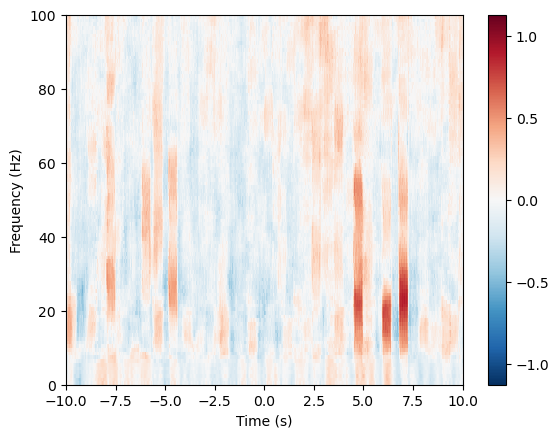

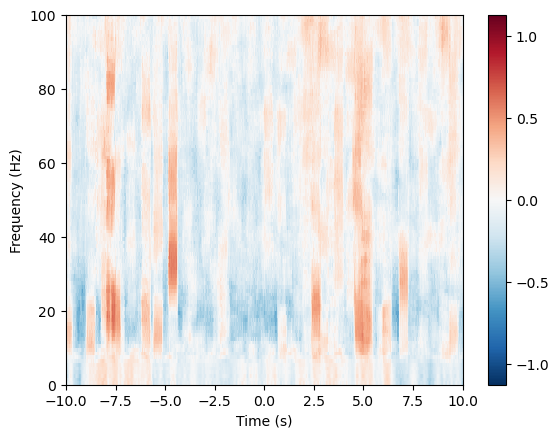

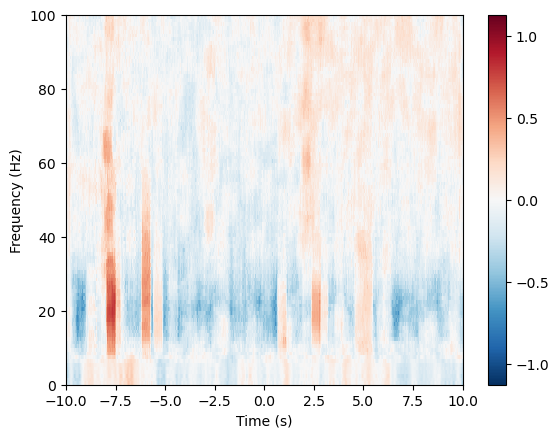

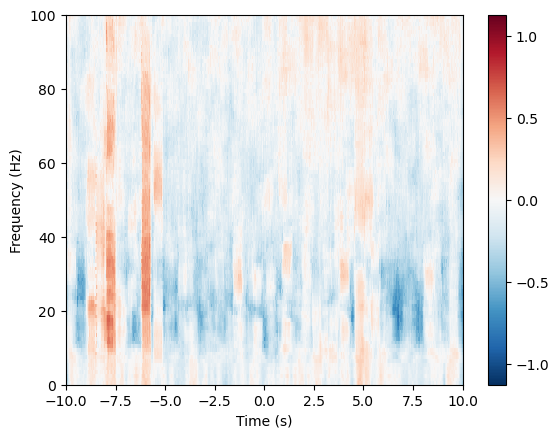

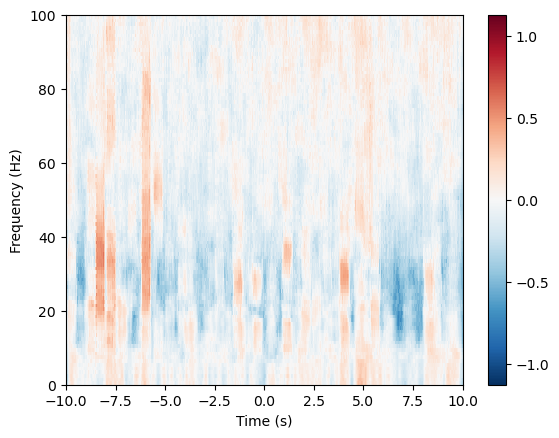

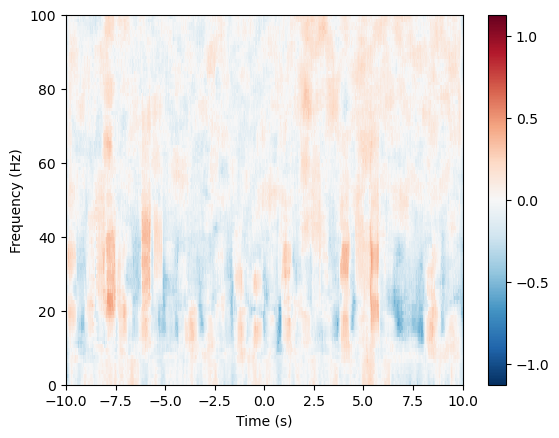

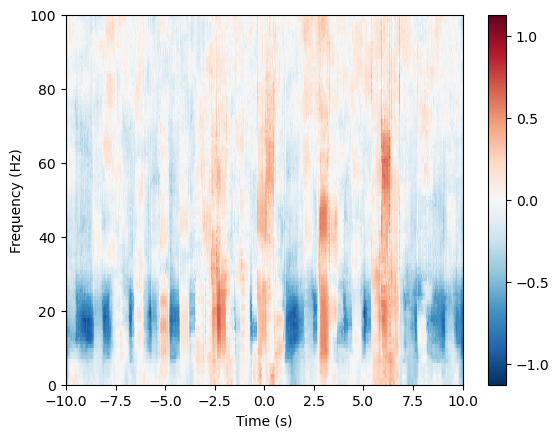

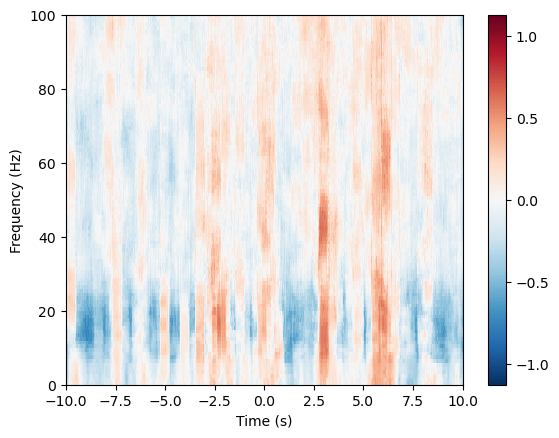

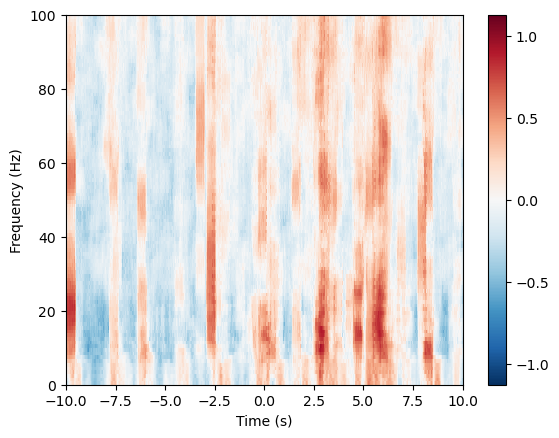

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

In [14]:
tfr_epochs_avg.plot(baseline = BASELINE, mode="logratio")

In [25]:
#tfr_epochs_ref.plot()
tfr_epochs.plot([0], baseline=(-5.0, 0.0), mode='mean', vmin=vmin, vmax=vmax,
               axes=ax, show=False, colorbar=False)

AttributeError: 'EpochsTFR' object has no attribute 'plot'